In [1]:
import os, argparse
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import wandb

import datasets
# from utils import select_device, natural_keys, gazeto3d, angular, getArch
from utils import select_device, natural_keys, gazeto3d, angular, getArch
from model import L2CS

In [2]:
# check if we have the correct number of checkpoint files 
ppath ='/project/results/output/snapshots/' 
for fold in range(15):
    foldstr = f"fold{fold:0>2}"
    cpath =os.path.join(ppath, foldstr)
    files = os.listdir(cpath)
    print(len(files), end=" ")

61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 

In [3]:
def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(
        description='Gaze estimation using L2CSNet .')
     # Gaze360
    parser.add_argument(
        '--gaze360image_dir', dest='gaze360image_dir', help='Directory path for gaze images.',
        default='datasets/Gaze360/Image', type=str)
    parser.add_argument(
        '--gaze360label_dir', dest='gaze360label_dir', help='Directory path for gaze labels.',
        default='datasets/Gaze360/Label/test.label', type=str)
    # mpiigaze
    parser.add_argument(
        '--gazeMpiimage_dir', dest='gazeMpiimage_dir', help='Directory path for gaze images.',
        default='datasets/MPIIFaceGaze/Image', type=str)
    parser.add_argument(
        '--gazeMpiilabel_dir', dest='gazeMpiilabel_dir', help='Directory path for gaze labels.',
        default='datasets/MPIIFaceGaze/Label', type=str)
    # Important args -------------------------------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------------------------------------------
    parser.add_argument(
        '--dataset', dest='dataset', help='gaze360, mpiigaze',
        default= "gaze360", type=str)
    parser.add_argument(
        '--snapshot', dest='snapshot', help='Path to the folder contains models.', 
        default='output/snapshots/L2CS-gaze360-_loader-180-4-lr', type=str)
    parser.add_argument(
        '--evalpath', dest='evalpath', help='path for the output evaluating gaze test.',
        default="evaluation/L2CS-gaze360-_loader-180-4-lr", type=str)
    parser.add_argument(
        '--gpu',dest='gpu_id', help='GPU device id to use [0]',
        default="0", type=str)
    parser.add_argument(
        '--batch_size', dest='batch_size', help='Batch size.',
        default=100, type=int)
    parser.add_argument(
        '--arch', dest='arch', help='Network architecture, can be: ResNet18, ResNet34, [ResNet50], ''ResNet101, ResNet152, Squeezenet_1_0, Squeezenet_1_1, MobileNetV2',
        default='ResNet50', type=str)
    # ---------------------------------------------------------------------------------------------------------------------
    # Important args ------------------------------------------------------------------------------------------------------
    args = parser.parse_args()
    return args

In [4]:
class Nothing:
    pass
args = Nothing()
args.gazeMpiimage_dir = '/project/data/Image'  # syn data 
args.gazeMpiilabel_dir = '/project/data/Label'  # syn label
args.output = '/project/results/soutput/snapshots/'  # real model
args.dataset = 'mpiigaze'
args.snapshot='/project/results/soutput/snapshots/'  # real data model
args.evalpath = '/project/results/rsoutput/evaluation/'
args.gpu_id = '0,1,2,3'
args.gpu_id = '0'
args.batch_size = 20
args.arch = 'ResNet50'
args.bins=28
args.angle = 180
args.bin_width = 4


In [5]:
batch_size=args.batch_size
arch=args.arch
data_set=args.dataset
evalpath =args.evalpath
snapshot_path = args.snapshot
bins=args.bins
angle=args.angle
bin_width=args.bin_width

In [6]:
!ls ../results

README	daoutput  output  rsoutput  soutput  sroutput


In [7]:
# args = parse_args()
cudnn.enabled = True
gpu = select_device(args.gpu_id, batch_size=args.batch_size)
transformations = transforms.Compose([
    transforms.Resize(448),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model_used=getArch(arch, bins)  #resnet50 and 28 bins

In [8]:
# fold=2
# folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
# folder.sort(key=natural_keys)
# folder.pop(-1)  #remove the tensorboard file
# # print(folder)
# epochs = folder[3]
# os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epochs)

In [9]:
# print(evalpath, snapshot_path)

In [10]:
# print(data_set)

In [11]:
%%time

pitch_errs = {}
yaw_errs = {}

for fold in range(15):
    print(f"fold={fold}")
    
    now = datetime.utcnow()
    now = now.astimezone(timezone('US/Pacific'))
    date_format='%m/%d/%Y %H:%M:%S'
    now = now.strftime(date_format)
    
    print(args.gazeMpiilabel_dir)
    folder = os.listdir(args.gazeMpiilabel_dir)
    folder.sort()  #individual label files
    testlabelpathcombined = [os.path.join(args.gazeMpiilabel_dir, j) for j in folder] 
#     print(testlabelpathcombined)
#     print(args.gazeMpiimage_dir)
    gaze_dataset=datasets.Mpiigaze(testlabelpathcombined, args.gazeMpiimage_dir, transformations, False, angle, fold)

    test_loader = torch.utils.data.DataLoader(
        dataset=gaze_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True)

    fold_path = os.path.join(evalpath, 'fold' + f'{fold:0>2}'+'/')  #for evaluation
#     print(f"fold_path is {fold_path}")
#     if not os.path.exists(fold_path):
#         os.makedirs(fold_path)

#     if not os.path.exists(os.path.join(evalpath, f"fold"+str(fold))):
#         os.makedirs(os.path.join(evalpath, f"fold"+str(fold)))

    # list all epochs for testing
    folder = os.listdir(os.path.join(snapshot_path, "fold" + f'{fold:0>2}'))
    folder.sort(key=natural_keys)
    folder.pop(-1)  #remove the tensorboard file, now all snapshot files
#     print(f"folder={folder}")  #contains all the checkpoint files
                    

    softmax = nn.Softmax(dim=1)
#     with open(os.path.join(evalpath, os.path.join("fold"+f'{fold:0>2}', data_set+".log")), 'w') as outfile:
        
    configuration = (f"\ntest configuration equal gpu_id={gpu}, batch_size={batch_size}, model_arch={arch}\n"
                     f"Start testing dataset={data_set}, FOLD={fold} --{now}---------")
    print(configuration)

#     outfile.write(configuration)
    epoch_list=[]
    avg_MAE=[]
    for epochs in folder: 
        x = ''.join(filter(lambda i: i.isdigit(), epochs))
        x = int(x)
        if x != 39:
            continue
#         print(f"epochs={epochs}")
        model=model_used
        checkpoint = torch.load(os.path.join(snapshot_path+"fold"+f'{fold:0>2}', epochs))
#         print(f"checkpoint={checkpoint}")
        saved_state_dict = checkpoint['model_state_dict']
        model= nn.DataParallel(model,device_ids=[0])
        model.load_state_dict(saved_state_dict)
        model.cuda(gpu)
        model.eval()
        total = 0
        idx_tensor = [idx for idx in range(28)]
        idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
        avg_error = .0
        
        print(f"epochs={epochs}")
        
        with torch.no_grad():
            for j, (images, labels, cont_labels, name) in enumerate(test_loader):
#                 print(f"name={name}")
                images = Variable(images).cuda(gpu)
                total += cont_labels.size(0)

                label_pitch = cont_labels[:,0].float()*np.pi/180
                label_yaw = cont_labels[:,1].float()*np.pi/180

                gaze_pitch, gaze_yaw = model(images)

                # Binned predictions
                _, pitch_bpred = torch.max(gaze_pitch.data, 1)
                _, yaw_bpred = torch.max(gaze_yaw.data, 1)

                # Continuous predictions
                pitch_predicted = softmax(gaze_pitch)
                yaw_predicted = softmax(gaze_yaw)

                # mapping from binned (0 to 28) to angels (-42 to 42)                
                pitch_predicted = \
                    torch.sum(pitch_predicted * idx_tensor, 1).cpu() * 3 - 42
                yaw_predicted = \
                    torch.sum(yaw_predicted * idx_tensor, 1).cpu() * 3 - 42

                pitch_predicted = pitch_predicted*np.pi/180
                yaw_predicted = yaw_predicted*np.pi/180

#                 print(f"name={name}")
#                 pitch_errors = []
#                 yaw_errors = []
#                 print("label_picthc", len(label_pitch), type(label_pitch), label_pitch)
#                 print("pitch_predicted", len(pitch_predicted), type(pitch_predicted), pitch_predicted)
#                 print("names", len(name), type(name), name)
                
                pitch_errors = (pitch_predicted - label_yaw)*180/np.pi
                tdict = dict(zip(name, pitch_errors))
                pitch_errs.update(tdict)
                
                yaw_errors = (yaw_predicted - label_pitch)*180/np.pi
                tdict = dict(zip(name, yaw_errors))
                yaw_errs.update(tdict)
                
                
#                 print("pitch_errors", len(pitch_errors), type(pitch_errors), pitch_errors)
                
#                 for idx, (p,y,pl,yl) in enumerate(zip(pitch_predicted, yaw_predicted, label_pitch, label_yaw)):
#                     angular_error = angular(gazeto3d([p,y]), gazeto3d([pl,yl]))
# #                         print(f"type OF angular error {type(angular_error)}")
# #                     print(f"angular error={angular_error}")
#                     avg_error += angular_error
#                     angular_error = angular_error.item()  #numpy float to float
#                     errors.append(angular_error)
#                 tdict = dict(zip(name, errors))
#                 ims_errs.update(tdict)
#         epoch_list.append(x)

fold=0
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=0 --06/17/2022 15:08:13---------
epochs=epoch_39.pkl
fold=1
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=1 --06/17/2022 15:08:31---------
epochs=epoch_39.pkl
fold=2
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=2 --06/17/2022 15:08:43---------
epochs=epoch_39.pkl
fold=3
/project/data/Label
0 items removed from dataset that have an angle > 180

test configuration equal gpu_id=cuda:0, batch_size=20, model_arch=ResNet50
Start testing dataset=mpiigaze, FOLD=3 --06/17/2022 15:08:55---------
epochs=epoch_39.pkl
fold=4
/proj

In [12]:
pitch_errs = dict(sorted(pitch_errs.items(), key=lambda item: item[1], reverse=True))
yaw_errs = dict(sorted(yaw_errs.items(), key=lambda item: item[1], reverse=True))

In [13]:
20*15/60

5.0

In [14]:
pitch_errors = np.array(list(pitch_errs.values()))
yaw_errors = np.array(list(yaw_errs.values()))

Text(0.5, 0, 'degree')

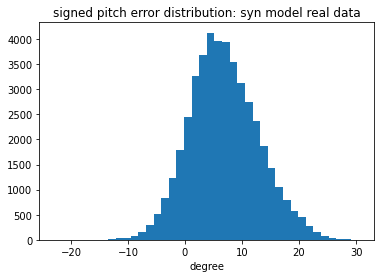

In [15]:
plt.hist(pitch_errors, bins=40)
plt.title("signed pitch error distribution: syn model real data")
plt.xlabel("degree")

Text(0.5, 0, 'degree')

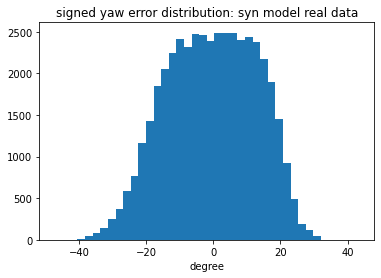

In [16]:
plt.hist(yaw_errors, bins=40)
plt.title("signed yaw error distribution: syn model real data")
plt.xlabel("degree")

In [17]:
sys.exit()

NameError: name 'sys' is not defined

In [ ]:
mean_error = errors.mean()
print(mean_error)

In [ ]:
ix = 0
for k, v in images_errors.items():
    if ix >20:
        break
    print(k, v)
    ix += 1

In [ ]:
len(images_errors)

In [ ]:
ix = 0
for k, v in images_errors.items():
    if ix >20:
        break
    print(k, v)
    ix += 1

In [ ]:
ix = 0
for k, v in images_errors.items():
    ix += 1
    if ix <44980:
        continue
    print(k, v)
    

In [ ]:
ix = 0
for k, v in images_errors.items():
    ix += 1
    if ix <22480 or ix >22500:
        continue
    print(k, v)